In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from os.path import join
from os import listdir

import multiprocessing as mp
from tqdm.auto import tqdm

from math import ceil, floor, sqrt

In [64]:
#Some ultilty functions
def mean(arr):
    return sum(arr) / len(arr)

# Analysis of scorers
This notebook contains experiments with regard to the different scoring functions for the grid search. <br>
Different scorering functions are compared to each other using multiple experiments. This is done at differnt levels of granularity:
1. All models with all runs
2. A single model with all runs
3. A single model with comparisons run by run

<br>
This allows us to compare the different scorers in depth. We can also use the results of this notebook in the paper itself.

In [65]:
df = pd.read_pickle("scorers_comparison/3sum_comparison.pickle")
df.columns.get_level_values(0).unique()

Index(['RandomUniform', 'Hamming', 'Beta', 'Dirichlet', 'HammingDirichlet'], dtype='object')

In [66]:
dirname = "scorers_comparison"
filename_suffix = "_comparison.pickle"

uniform_scorers = ['RandomUniform', 'Hamming', 'Beta', 'Dirichlet', 'HammingDirichlet']
prior_scorers = ['HammingDirichlet', "Dirichlet","SamplePrior", "SortedPrior"]

scorers = uniform_scorers

from parameters import defaults
from utils import config_id

grid_data = pd.read_pickle("grid_search.pickle")
default_id = config_id(defaults)

In [67]:
filenames = listdir(dirname)
model_names = [name.replace(filename_suffix,"") for name in filenames]

dummy = pd.read_pickle(join(dirname,filenames[0]))

iterations = dummy.index + 1 #Fixin weird plot artifacts using semilogx
num_runs = len(dummy.columns.get_level_values(1).unique())
print(f"Found {len(iterations)} iterations in dataframe")
print(f"Found {num_runs} runs for each algorithm")

Found 13608 iterations in dataframe
Found 10 runs for each algorithm


### Normalization
In the following cell, we normalize the runtimes. <br>
For every run, the runtime at each iteration is modified as follows: (default - runtime) / (default - optimal)

In [68]:
# Clean dataframes, i.e. remove wallclocktime and drop one level
dfs = [pd.read_pickle(join(dirname, fname)) for fname in filenames]

for i in tqdm(range(len(dfs)), desc="Cleaning dataframes"):
    df = dfs[i]
    df = df.drop(columns=["wall", "config_id"], level=2)
    df = df.droplevel(2, axis="columns")
    df.columns = df.columns.set_levels([f"runtime {s}" for s in range(num_runs)], level=1)
    # Prepend default runtime

    dfs[i] = df


Cleaning dataframes: 100%|██████████| 190/190 [00:02<00:00, 69.72it/s]


In [69]:

rel_improvement = pd.DataFrame(index=iterations,columns=pd.MultiIndex.from_product([scorers, ["median", "25th percentile", "75th percentile",]]), dtype=float)


pbar = tqdm(total=len(scorers)*len(model_names))

for i,algo in enumerate(scorers):
    pbar.set_description(f"{algo}")

    seed_names = [f"runtime {seed}" for seed in range(num_runs)]
    df_algo = pd.DataFrame(index=iterations, columns=pd.MultiIndex.from_product([model_names, seed_names]))
    for model_name, df in zip(model_names, dfs):
        default_time = grid_data[model_name].iloc[default_id].mean()
        rel = df[algo].apply(lambda x : (default_time - x) / (default_time - x.iloc[-1]))
        df_algo[model_name] = rel
        pbar.update()

    rel_improvement[algo, "median"] = df_algo.median(axis=1)
    rel_improvement[algo, "25th percentile"] = df_algo.quantile(0.25, axis=1)
    rel_improvement[algo, "75th percentile"] = df_algo.quantile(0.75, axis=1)
    rel_improvement[algo, "mean"] = df_algo.mean(axis=1)

# Fixing plotting issues
# Add relative runtime of 0 to dataframe
rel_improvement.loc[0] = 0
rel_improvement = rel_improvement.sort_index()
rel_improvement.index += 1


SamplePrior:  50%|█████     | 380/760 [17:33<17:33,  2.77s/it]


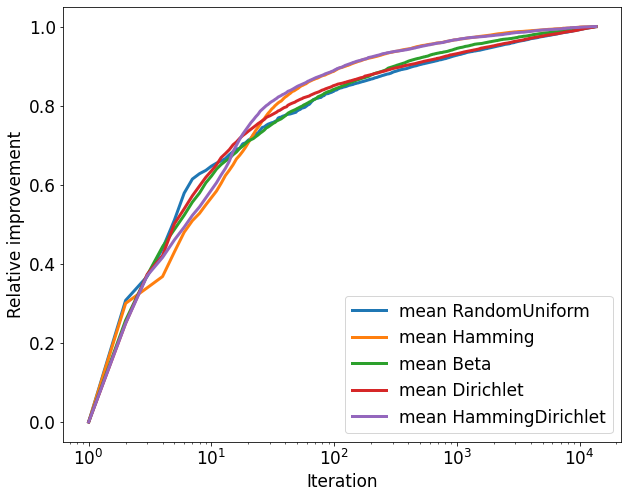

In [70]:
#Same data but in one plot
fig, ax = plt.subplots(1,1, figsize=(10,8))

for i, algo in enumerate(scorers):   

    imp = rel_improvement[algo]
    plt.semilogx(imp.index, imp['mean'], label=f"mean {algo}", linewidth=3)
    # ax.fill_between(iterations, imp['25th percentile'], imp['75th percentile'], alpha=0.2)

ax.legend(loc="lower right", prop={"size":17})
ax.set_xlabel("Iteration", fontsize=17)
ax.set_ylabel("Relative improvement", fontsize=17)
ax.tick_params(axis="x", labelsize=17)
ax.tick_params(axis="y", labelsize=17)

In [71]:
# Same data but tabular
slices = [10, 100, 1000, 10000]
means = rel_improvement[[(s,"mean") for s in scorers]]
means  = means.droplevel(axis="columns", level=1)

styler = means.T[slices].style
styler = styler.format(precision=2)

styler.highlight_max(axis="rows")


,10,100,1000,10000
RandomUniform,0.65,0.84,0.93,0.99
Hamming,0.57,0.89,0.97,1.00
Beta,0.62,0.84,0.94,0.99
Dirichlet,0.63,0.85,0.93,0.99
HammingDirichlet,0.59,0.89,0.97,1.00
